# Анализ по выявлению критериев успешной игры 

**Описание задачи**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных**

* Name — название игры


* Platform — платформа


* Year_of_Release — год выпуска


* Genre — жанр игры


* NA_sales — продажи в Северной Америке (миллионы проданных копий)


* EU_sales — продажи в Европе (миллионы проданных копий)


* JP_sales — продажи в Японии (миллионы проданных копий)


* Other_sales — продажи в других странах (миллионы проданных копий)


* Critic_Score — оценка критиков (максимум 100)


* User_Score — оценка пользователей (максимум 10)


* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). 


Данные за 2016 год могут быть неполными.

## Первичная обработка файла

Открываем файл загружаем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as mplt
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

Приводим названия столбцов к единому формату

In [3]:
data.columns = data.columns.str.lower()

## Работа с пропусками и дубликатами

In [4]:
# Проверка количества пропусков 
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (18,6), rot = -5, legend = False, fontsize = 14)
            .set_title('Процент пропусков по столбцам' + "\n", fontsize = 22)   
            
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

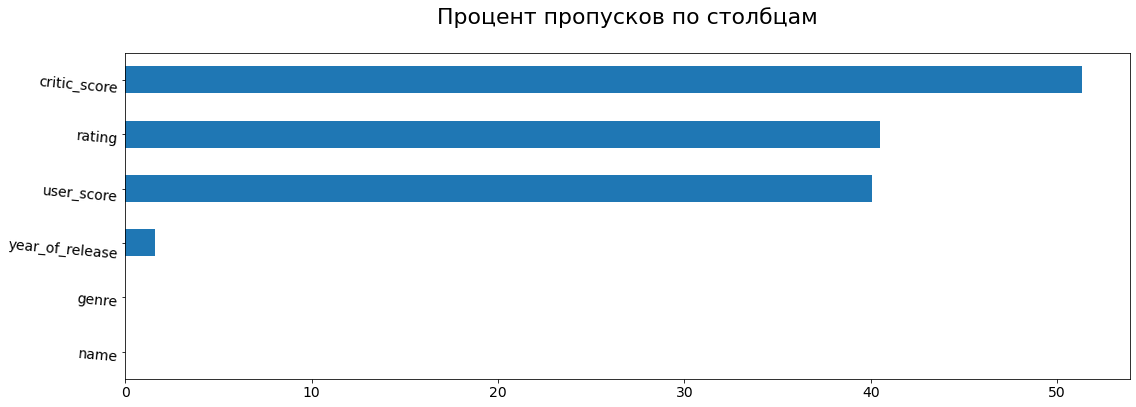

In [5]:
pass_value_barh(data)

In [6]:
# Поверим пропущенные данные
data_no_name = data[data['name'].isna()]
data_no_name

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [7]:
# Поверим пропущенные данные
data_no_year = data[data['year_of_release'].isna()]
data_no_year['na_sales'].mean()

0.21988847583643123

In [8]:
# Поверим пропущенные данные
data_no_genre = data[data['genre'].isna()]
data_no_genre

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# Удалим пропуски в столбцах с названием, жанром, годом выхода
data = data.dropna(subset = ['name', 'year_of_release', 'genre'])

Пропуски в critic_score, user_score и rating заполнить проблематично, а удалять данные не рационально, решено было оставить как есть

In [10]:
# Поиск явных дубликатов
duplicateRows = data[data.duplicated(['name', 'platform', 'year_of_release'])]
duplicateRows

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


## Работа с типами данных

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [12]:
# значение tbd говорит о том, что рейтинг пока не выставлен
# было принято решение при смене типа данных перевести все tbd в Nа
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

# год релиза приводим к целочисленному значению
data['year_of_release'] = data['year_of_release'].astype('int')

data = data.reset_index()

In [13]:
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [14]:
# Раскидаем редко встречающиеся рейтинги на более популярные группы близкие по значению
data['rating'] = data['rating'].replace('K-A','E')
data['rating'] = data['rating'].replace('EC','E')
data['rating'] = data['rating'].replace('AO','M')

In [15]:
# Заполним пропуски самым популярным рейтингом в жанре, про RP - рейтинг ожидается, тоже не забудем
for i in range(len(data)):
    if (pd.isna(data.loc[i, 'rating'])) or (data.loc[i,'rating'] == 'RP'):
        genre = data.loc[i, 'genre']
        data.loc[i, 'rating'] = data[data['genre'] == genre]['rating'].value_counts().index[0]

In [16]:
# Проверка
data['rating'].value_counts()

E       7690
T       5524
M       1837
E10+    1393
Name: rating, dtype: int64

## Анализ данных

### Общий анализ платформ

In [17]:
# Создаем столбец с общими продажами
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [18]:
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T,31.38


Количество выпускаемых игр по годам

<AxesSubplot:title={'center':'Количество выпущенных игр по годам'}, xlabel='Год релиза', ylabel='Количество игр'>

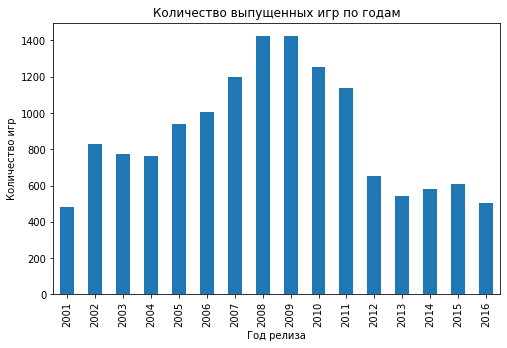

In [19]:
# Визуализируем данные о выпускаемых играх после 2001 года
release_by_year = data.pivot_table(values = 'name', index = 'year_of_release', aggfunc = 'count')

release_by_year.query('year_of_release >= 2001').plot(kind = 'bar', figsize = (8,5), legend = '',
                                                      title = 'Количество выпущенных игр по годам',
                                                      xlabel = 'Год релиза', ylabel = 'Количество игр')


Из уже выделенных данных наиболее важными являются с 2009 года, так как они показывают на спад количества издаваемых игр, но период 2013-2015 показал незначительный рост, так как данные за 2016 год не полные, судить об окончательной тенденции рано.

In [20]:
sales_by_platform = (data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
    .sort_values(by = 'total_sales', ascending = False).head(10))
best_pl = sales_by_platform.index

In [21]:
best_pl_sales = data.pivot_table(index = ['platform', 'year_of_release'],
                                 values = 'total_sales',
                                 aggfunc = 'sum')

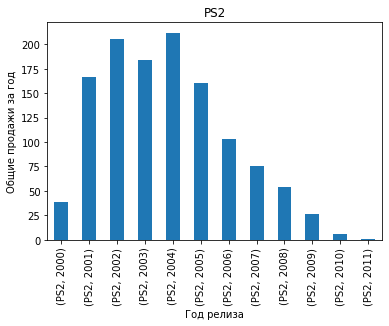

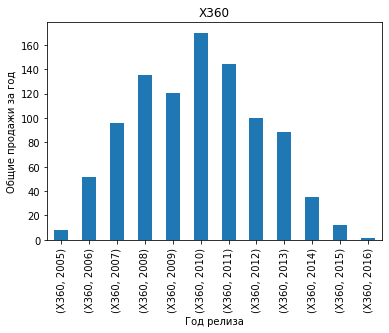

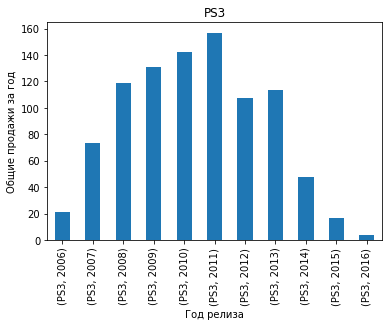

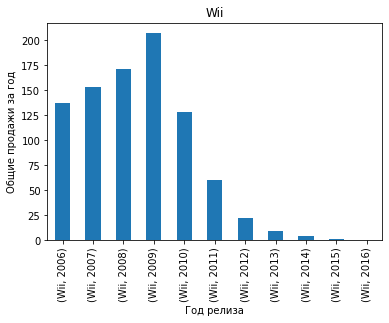

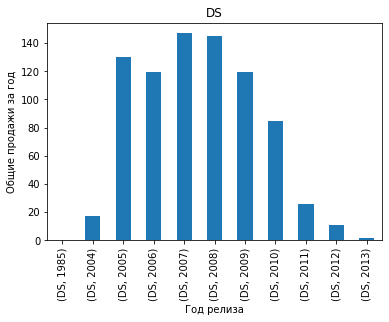

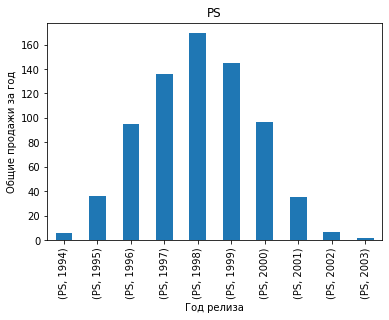

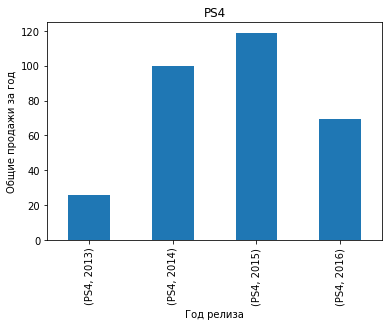

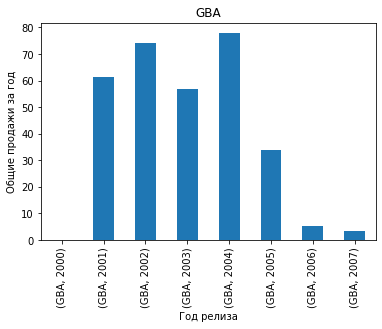

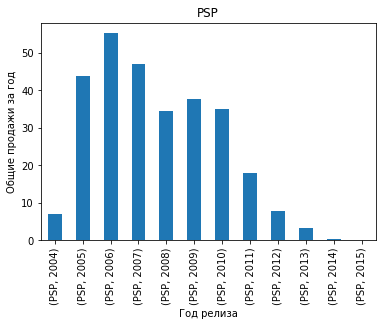

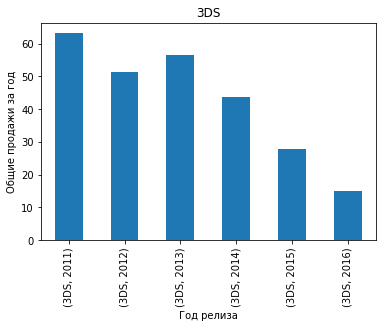

In [22]:
for plt in best_pl:
    plot = best_pl_sales.query('platform == @plt').plot(kind = 'bar', 
                                                        title = plt,
                                                        legend = '',
                                                        ylabel = 'Общие продажи за год',
                                                        xlabel = 'Год релиза')

В среднем продолжительность жизни платформы 8 лет

Актуальный период возьмем с 2014 года

In [23]:
# Выделим из датафрейма актуальный период
data_new = data.query('year_of_release >= 2014').reset_index()

In [24]:
platf_actual = data_new.pivot_table( index = ['platform','year_of_release'], values = 'total_sales')
platf_actual

total_sales
platform year_of_release             
3DS      2014                0.547000
         2015                0.323023
         2016                0.329130
PC       2014                0.282553
         2015                0.170400
         2016                0.097222
PS3      2014                0.442222
         2015                0.230411
         2016                0.094737
PS4      2014                1.333333
         2015                0.867883
         2016                0.422256
PSP      2014                0.024000
         2015                0.040000
PSV      2014                0.119000
         2015                0.056818
         2016                0.050000
Wii      2014                0.625000
         2015                0.285000
         2016                0.180000
WiiU     2014                0.710645
         2015                0.583929
         2016                0.328571
X360     2014                0.551429
         2015                0.341714
         2016                0.116923
XOne     2014                0.886393
         2015                0.751750
         2016                0.300575

В актуальном периоде лидруют по продажам Xbox One и PS4.
Потенциальный рост могут показать только эти же две платформы (Xbox One и PS4) в том случае, если данные за 2016 год продолжат динамику 2014-2015.

Text(0.5, 0, 'Общие продажи')

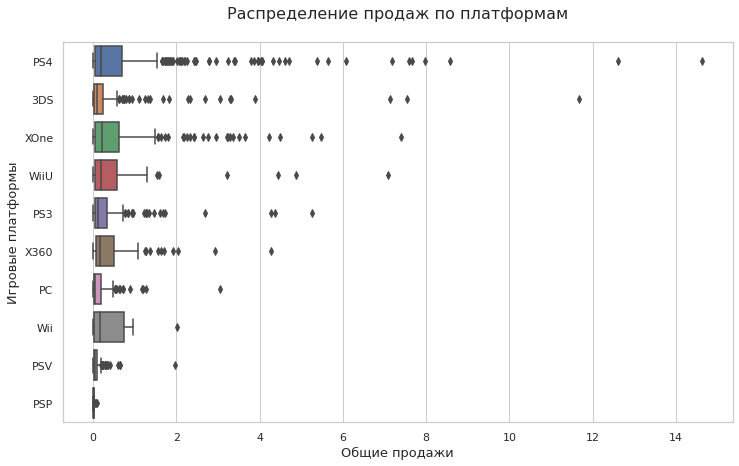

In [25]:
# Построим график ящик с усами по продажам у платформ
sns.set(style="whitegrid")

mplt.figure(figsize=(12, 7))

ax = sns.boxplot(x="total_sales", 
            y="platform", 
            data=data_new)
ax.set_title('Распределение продаж по платформам' + '\n', fontsize = 16)
ax.set_ylabel('Игровые платформы', fontsize = 13)
ax.set_xlabel('Общие продажи', fontsize = 13)

Text(0.5, 0, 'Общие продажи')

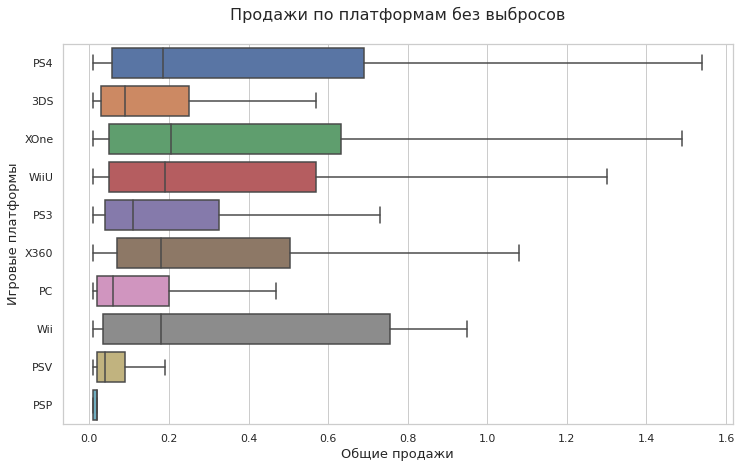

In [26]:
# Уберем выбросы
mplt.figure(figsize=(12, 7))

ax = sns.boxplot(x="total_sales", 
            y="platform", 
            data=data_new, 
            showfliers=False)

ax.set_title('Продажи по платформам без выбросов' + '\n', fontsize = 16)
ax.set_ylabel('Игровые платформы', fontsize = 13)
ax.set_xlabel('Общие продажи', fontsize = 13)

Из графика ящик с усами можно наглядно увидеть высокую продаваемость PS4: высокое положение медианы и 3 квартиля. Относительно высокие показатели продаваемости так же 
у XOne и WiiU. Можно так же указать на аутсайдера продаж за актуальный период - PSP. 
30-тилетняя история персональных компьютеров говорит, что игры для PC так же можно включить в рекомендацию.


### Корреляционный анализ оценок и продаваемости

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


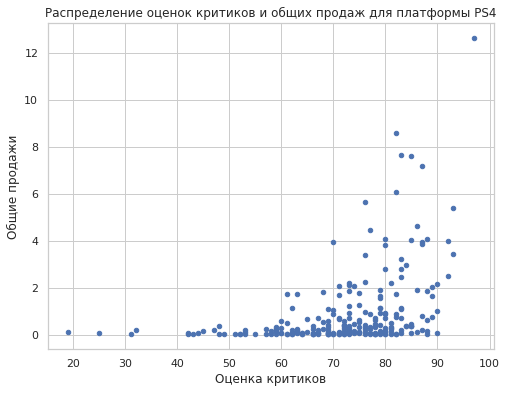

In [46]:
# Построим распределение оценок критиков и общих продаж для платформы PS4
data_new_ps4 = data_new.query('platform == "PS4"')
data_new_ps4.sort_values('critic_score').plot(x = 'critic_score',
                                              y = 'total_sales', 
                                              kind = 'scatter',
                                              title = 'Распределение оценок критиков и общих продаж для платформы PS4',
                                              ylabel = 'Общие продажи',
                                              xlabel = 'Оценка критиков',
                                              figsize = (8,6))

corr = data_new_ps4['critic_score'].corr(data_new_ps4['total_sales'])

In [28]:
print('Корреляция между оценкой критиков и продажами игр =', round(corr, 3))

Корреляция между оценкой критиков и продажами игр = 0.403


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


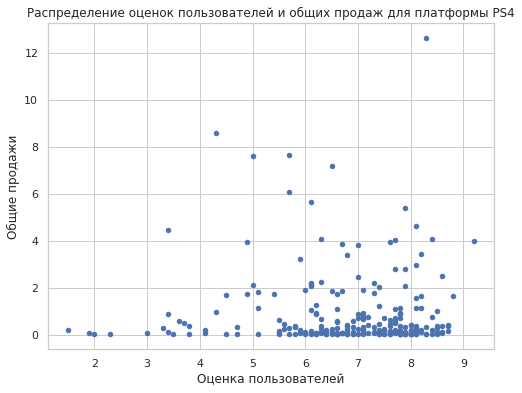

In [29]:
# Построим распределение оценок пользователей и общих продаж для платформы PS4
data_new_ps4.sort_values('user_score').plot(x = 'user_score',
                                            y = 'total_sales',
                                            kind = 'scatter',
                                            title = 'Распределение оценок пользователей и общих продаж для платформы PS4',
                                            ylabel = 'Общие продажи',
                                            xlabel = 'Оценка пользователей',
                                            figsize = (8,6))

corr = data_new_ps4['user_score'].corr(data_new_ps4['total_sales'])

In [30]:
print('Корреляция между оценкой пользователей и продажами игр =', round(corr, 3))

Корреляция между оценкой пользователей и продажами игр = -0.04


Распределение оценок критиков относительно продаж очевидно имеет тенденцию к прямой пропорциональности. Корреляционный анализ
Пирсона так же это подтверждает, 0.41 - высокий уровень связи.

Про оценки пользователей такого не скажешь, распределение менее оформленое, корреляционный анализ показывает
связь близкую к нулю.
Можно сделать предположение, что корреляция есть только между оценками критиков и продаваемостью

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


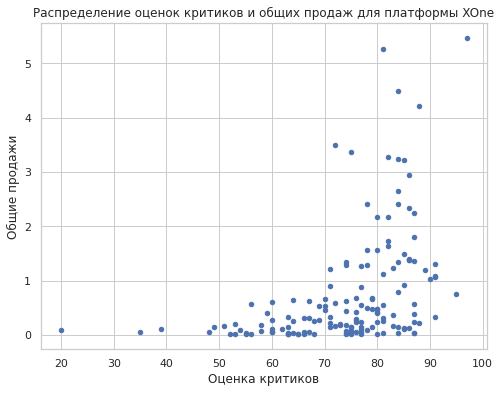

In [47]:
# Построим распределение оценок критиков и общих продаж для платформы XOne
data_new_xone = data_new.query('platform == "XOne"')
data_new_xone.sort_values('critic_score').plot(x = 'critic_score', 
                                               y = 'total_sales', 
                                               kind = 'scatter',
                                               title = 'Распределение оценок критиков и общих продаж для платформы XOne',
                                               ylabel = 'Общие продажи',
                                               xlabel = 'Оценка критиков',
                                               figsize = (8,6))
corr = data_new_xone['critic_score'].corr(data_new_xone['total_sales'])

In [32]:
print('Корреляция между оценкой критиков и продажами игр =', round(corr, 3))

Корреляция между оценкой критиков и продажами игр = 0.429


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


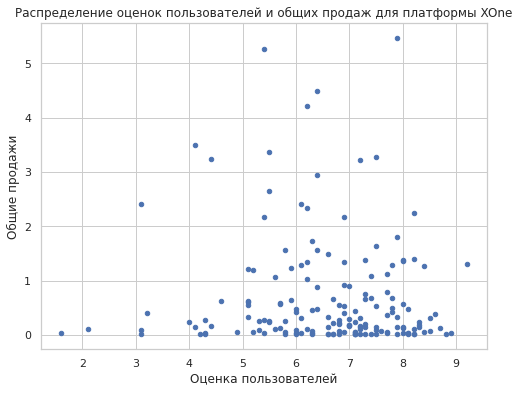

In [33]:
# Построим распределение оценок пользователей и общих продаж для платформы XOne
data_new_xone.sort_values('user_score').plot(x = 'user_score', 
                                             y = 'total_sales', 
                                             kind = 'scatter',
                                             title = 'Распределение оценок пользователей и общих продаж для платформы XOne',
                                             ylabel = 'Общие продажи',
                                             xlabel = 'Оценка пользователей',
                                             figsize = (8,6))
corr = data_new_xone['user_score'].corr(data_new_xone['total_sales'])

In [34]:
print('Корреляция между оценкой пользователей и продажами игр =', round(corr, 3))

Корреляция между оценкой пользователей и продажами игр = -0.07


Для сравнения был проведен такой же анализ платформы Xbox One, распределение и результаты корреляционного анализа оказались схожими

### Анализ прибыльности жанров

Text(0.5, 0, 'Общие продажи')

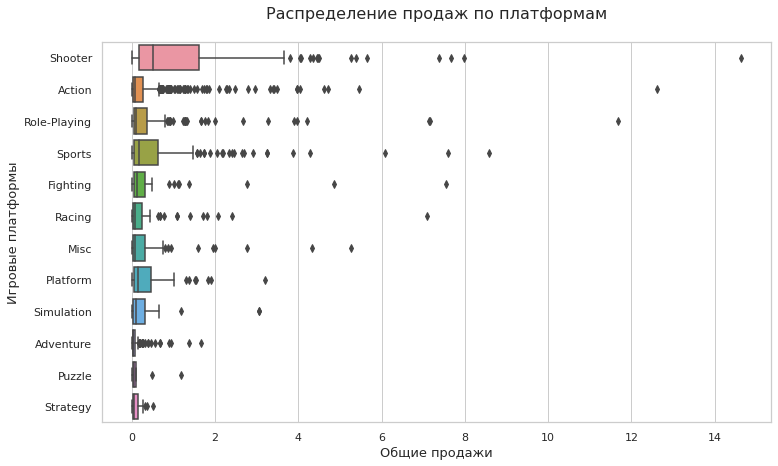

In [35]:
# Построим диаграму ящик с усами по продажам жанров

mplt.figure(figsize=(12, 7))

ax = sns.boxplot(x="total_sales", 
                 y="genre", 
                 data=data_new)
ax.set_title('Распределение продаж по платформам' + '\n', fontsize = 16)
ax.set_ylabel('Игровые платформы', fontsize = 13)
ax.set_xlabel('Общие продажи', fontsize = 13)

Text(0.5, 0, 'Общие продажи')

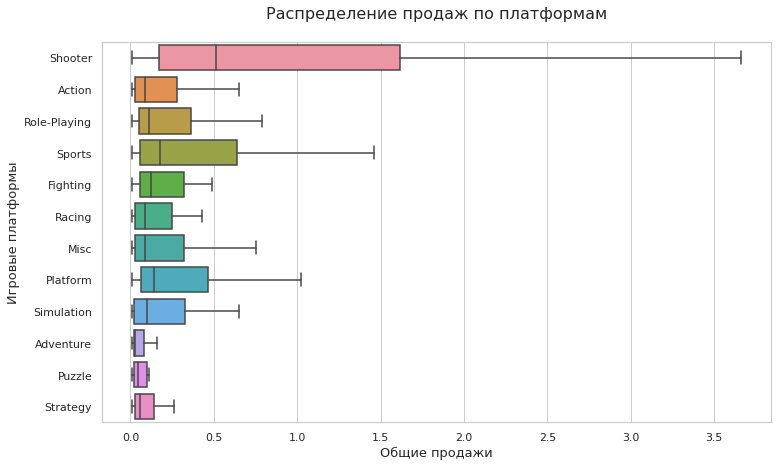

In [36]:
# Уберем выбросы
mplt.figure(figsize=(12, 7))

ax = sns.boxplot(x="total_sales", 
                 y="genre", 
                 data=data_new,
                 showfliers=False)
ax.set_title('Распределение продаж по платформам' + '\n', fontsize = 16)
ax.set_ylabel('Игровые платформы', fontsize = 13)
ax.set_xlabel('Общие продажи', fontsize = 13)

По результатам анализа жанров самыми прибыльными оказались: спорт и шутер, наименее прибыльными: пазлы и приключения.

### Анализ региональных предпочтений

#### Жанровые предпочтения

In [37]:
def top(country, category):
    
    ct_genre = (data_new.pivot_table(index = category, values = country, aggfunc = 'sum')
        .sort_values(country, ascending = False))
    ct_genre.reset_index()
    
    if category == 'genre':
        smth = 'жанров'
    else: smth = 'платформ'
        
    if country == 'eu_sales':
        name = 'Европе'
    elif country == 'na_sales':
        name = 'Северной Америке'
    elif country == 'jp_sales':
        name = 'Японии'
        
    a = 0.1*ct_genre[country].max()
    big_part = ct_genre[ct_genre[country] >= a]
    small_part = ct_genre[ct_genre[country] < a]
    other = pd.DataFrame([small_part.sum()], index=["Other"])
    ct_genre = big_part.append(other)
    
    ct_genre = ct_genre.sort_values(by = country, ascending = False)
    ct_genre.plot(kind = 'pie', 
                  subplots=True,
                  autopct='%1.0f%%',
                  figsize = (16,6), 
                  wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                  textprops={'size': 'x-large'},
                  legend=False, 
                  ylabel='')
    mplt.title(f"Популярность {smth} в {name} ", fontsize=16)


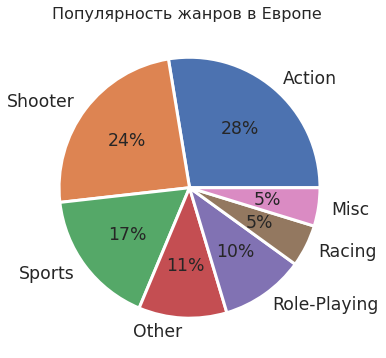

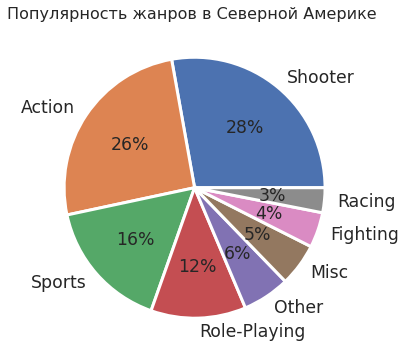

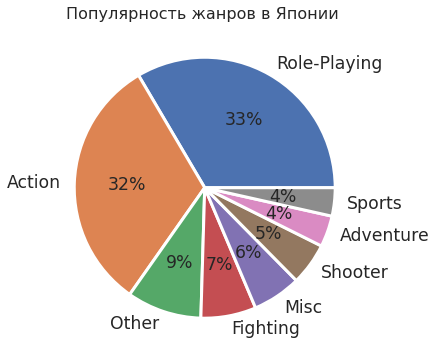

In [38]:
top('eu_sales','genre')
top('na_sales','genre')
top('jp_sales','genre')

Самые популярные жанры в Европе: Экшен, Шутер и Спорт, в Северной Америке такие же, на японском рынке явно преобладают РП игры и уже за тем идет экшен. Вероятно это связано с культурными особенностями региона.

#### Платформенные предпочтения

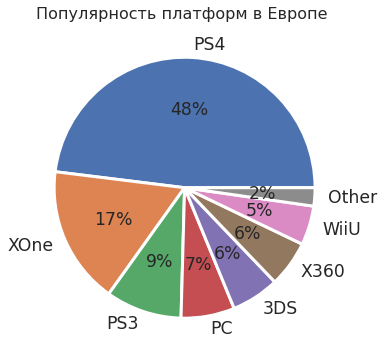

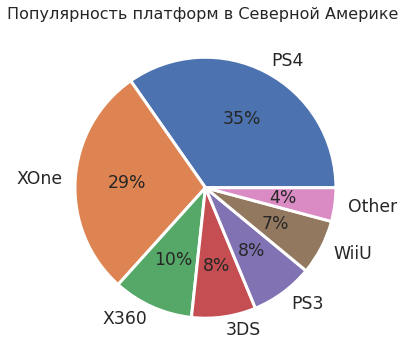

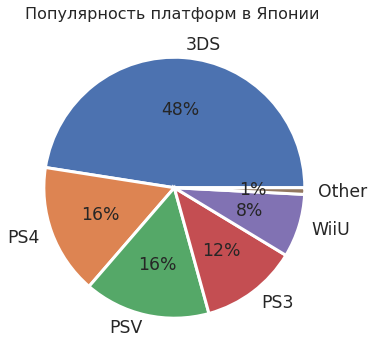

In [39]:
top('eu_sales','platform')
top('na_sales','platform')
top('jp_sales','platform')

Больше всего денег на Европейском рынке приносят PS4, на Американском - XOne, на Японском - Nintendo 3DS

#### Предпочтения по рейтингу

In [40]:
def top2(country):
    ct_genre = (data_new.pivot_table(index = 'rating', values = country, aggfunc = 'sum')
        .sort_values(country, ascending = False))
    ct_genre = ct_genre.sort_values(by = country, ascending = False)
    
    if country == 'eu_sales':
        name = 'Европе'
    elif country == 'na_sales':
        name = 'Северной Америке'
    elif country == 'jp_sales':
        name = 'Японии'
    
    ct_genre.plot(kind = 'pie',
                  figsize = (15,6),
                  autopct='%1.0f%%',
                  subplots=True, 
                  legend = False,
                  wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                  textprops={'size': 'x-large'},
                  ylabel='')
    mplt.title(f'Популярность возрастных рейтингов в {name}', fontsize=15)

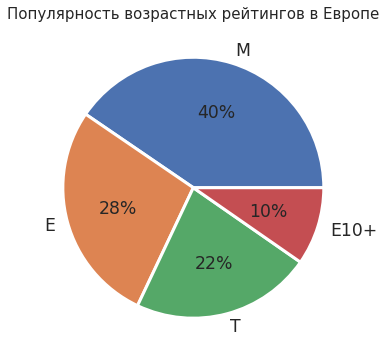

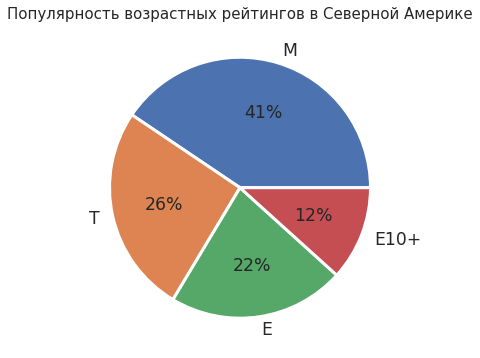

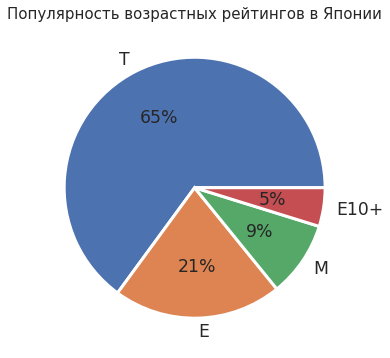

In [41]:
top2('eu_sales')
top2('na_sales')
top2('jp_sales')

Больше всего денег на Европейском и Американском рынке приносят игры для возраста 17+(М), а так же для всех возрастов (Е). На Японском рынке популярным является рейтинг T.

## Проверка гипотез

In [42]:
# Подготовка данных
data_new = data_new.dropna(subset = ['user_score'])
user_score_xone = data_new.query('platform == "XOne"')
user_score_pc = data_new.query('platform == "PC"')

### Первая гипотеза

**Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC равны

**Альтернативная гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC различны

**Уровень значимости:** 0,05

In [43]:
results = st.ttest_ind(user_score_xone['user_score'], user_score_pc['user_score'], equal_var = False)
alpha = 0.05
print('Значение pvalue =', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение pvalue = 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


По результатам статистического анализа вероятность получить ошибку первого рода, отвергнув нулевую гипотезу составляет 12%, что больше, обусловленного уровня значимости в 5%. Нулевую гипотезу не отвергаем. 

**Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action и Sports одинаковые

**Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action и Sports разные

**Уровень значимости:** 0,05

In [44]:
results = (st.ttest_ind(data_new[data_new['genre'] =='Action']['user_score'], data_new[data_new['genre'] =='Sports']
                       ['user_score'], equal_var = False))
alpha = 0.05
print('Значение pvalue =', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение pvalue = 1.1825550382644557e-14
Отвергаем нулевую гипотезу


По результатам статистического анализа вероятность получить ошибку первого рода, отвергнув нулевую гипотезу стремится к нулю (1,18e-14), что меньше, обусловленного уровня значимости в 5%. Нулевую гипотезу отвергаем. 

## Общий вывод

*В ходе предобработки данных были преобразованы типы данных, обработаны пропуски, дубликаты не были выявлены. В ходе непосредственного анализа был выявлен ряд закономерностей определяющих успешность игры.*

* Если говорить об общемировых тенденциях, то успешная игра обязательно должна быть портирована на платформы Xbox One, PS4 или же WiiU, как наиболее продаваемые. Но в отдельных регионах ситуация может варьироваться. Так в Японии хорошо продаются игры на 3DS; Северной Америке - PS4, XOne; Европе - PS4

* Опять же, на общемировом рынке наиболее успешными жанрами являются Спорт и Шутер, наименее выгодными Стратегии и Приключения

* Самыми продаваемыми играми во всех трех рассмотренных регионах (Северная Америка, Европа, Япония) являются игры с рейтингом M (17+)

* Определенно точно существует корреляция между высокими оценками критиков и продаваемостью игр, это стоит учитывать при планировании кампании

* Корреляции между оценками пользователей и продаваемостью не выявлено

*Так же при помощи критерия Стьюдента были проверены предлагаемые гипотезы. В результате чего получены следущие выводы:*

- Средние пользовательские рейтинги платформ Xbox One и PC статистически не различимы при уровне значимости альфа = 0,05

- Средние пользовательские рейтинги жанров Action и Sports статистически достовено различаются при уровне значимости альфа = 0,05
